## Import Libraries

In [ ]:
import torch
import numpy as np
import random
from collections import namedtuple
from collections import deque
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import torch
import matplotlib.pyplot as plt
import time
from unityagents import UnityEnvironment

## Load environment
###  20 agents in this case

In [1]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Set seed for reproducibility

In [2]:
SEED = 42
device = 'cuda:0' if torch.cuda.is_available() else 'cpu:0'

## Notes from the article
1) Need a replay bufffer class;
2) Need a class for a target Q network (function of s, a);
3) Use batch norm; 
- it did not worked out well so I removed it;
4) The policy is deterministic, how to handle explore / exploit?;
5) We have two actor and two critic networks, a target for each;
6) Updates are soft, accorsing to: theta_prime = tau * theta + (1 - tau) * theta_prime, with tau << 1;
7) The target actor is just the evaluation actor plus some noise process;
8) They use Ornstein uhlenbeck or Gaussian Noise. It will need a class for noise;

## Build the Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, seed, buffer_size, batch_size):
        random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple(
            'Experience',
            field_names=['state', 'action', 'reward', 'next_state', 'done']
        )

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def add_batch(self, states, actions, rewards, next_states, dones):
        for state, action, reward, next_state, done in \
                zip(states, actions, rewards, next_states, dones):
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)

    def create_tensor(self, data):
        return torch.from_numpy(np.vstack(data)).float().to(device)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = self.create_tensor(states)
        actions = self.create_tensor(actions)
        rewards = self.create_tensor(rewards)
        next_states = self.create_tensor(next_states)
        dones = self.create_tensor(dones)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

replay_buffer = ReplayBuffer(
    seed=SEED,
    buffer_size=int(1e5),
    batch_size=64
)

## Extract information from the environment

In [4]:
# Extract state dimensionality from env.
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=True)[brain_name]
state_size = env_info.vector_observations.shape[-1]

# Extract action dimensionality and number of agents from env.
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size
num_agents = len(env_info.agents)

# Display relevant environment information.
print(f'Number of agents: {num_agents},'
      + f'state size: {state_size} '
      + f', action size: {action_size}')

Number of agents: 20,state size: 33 , action size: 4


## Build the Actor and Critics Neural Networks

In [5]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units, fc2_units):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self._hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*self._hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

    def _hidden_init(self, layer):
        fan_in = layer.weight.data.size()[0]
        lim = 1. / np.sqrt(fan_in)
        return -lim, lim


class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units, fc2_units):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*self._hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*self._hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        x = F.relu(self.fc1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def _hidden_init(self, layer):
        fan_in = layer.weight.data.size()[0]
        lim = 1. / np.sqrt(fan_in)
        return -lim, lim

# Initialize local and target Actor Networks and optimizer.
actor_local = Actor(state_size, action_size, SEED,
                    128, 256).to(device)
actor_target = Actor(state_size, action_size, SEED,
                        128, 256).to(device)
actor_optimizer = optim.Adam(actor_local.parameters(), lr=.000025)

# Initialize local and target Critic Networks and optimizer.
critic_local = Critic(state_size, action_size, SEED,
                        128, 256).to(device)
critic_target = Critic(state_size, action_size, SEED,
                        128, 256).to(device)
critic_optimizer = optim.Adam(critic_local.parameters(), lr=0.00025,
                                weight_decay=0)

## Add noise for exploration matter
### the rnstein-Uhlenbeck process or generating noise did not work out well for me so I succesfully replaced it for a gaussian noise

In [11]:
class GaussianNoise:
    def __init__(self, size, seed, mu, sigma):
        random.seed(seed)
        self.size = size
        self.mu = mu
        self.sigma = sigma

    def sample(self):
        return np.random.normal(self.mu, self.sigma, self.size)

# Initialize Gaussian noise to reduce generalization error.
noise = GaussianNoise(action_size, SEED, mu=0.0, sigma=0.3)

## Create the agent
- The choices regargind tau I got it by trying it myself because according to the article, I should have used 0.00025 and 0.000025 for actor and critics and it did not work out at all;
- gamma kept the same as recommended by the paper;
- batch size as well;

In [7]:
class Agent:
    def __init__(self, seed, memory, batch_size, actor_local,
                 actor_target, actor_optimizer, critic_local, critic_target,
                 critic_optimizer, noise, gamma, tau):
        random.seed(seed)
        self.actor_local = actor_local
        self.actor_target = actor_target
        self.actor_optimizer = actor_optimizer
        self.critic_local = critic_local
        self.critic_target = critic_target
        self.critic_optimizer = critic_optimizer
        self.memory = memory
        self.batch_size = batch_size
        self.noise = noise
        self.gamma = gamma
        self.tau = tau

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)

        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def add_experience(self, states, actions, rewards, next_states, dones):
        self.memory.add_batch(states, actions, rewards, next_states, dones)

    def step(self):
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_current = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_current, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in \
                zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(
                tau * local_param.data + (1.0 - tau) * target_param.data
            )

# Create agent object used for training.
agent = Agent(
    seed=SEED,
    memory=replay_buffer,
    batch_size=128,
    actor_local=actor_local,
    actor_target=actor_target,
    actor_optimizer=actor_optimizer,
    critic_local=critic_local,
    critic_target=critic_target,
    critic_optimizer=critic_optimizer,
    noise=noise,
    gamma=0.99,
    tau=0.1
)

## Create a trainer
- As recommended by Udacity, I tried the update frequency 20 and number of updating 10 but it did not work out for me;

In [8]:
class DDPGTrainer:
    def __init__(self, env, agent, update_frequency, num_updates,
                 max_episode_length, save_dir, score_window_size):
        self.env = env
        self.brain_name = env.brain_names[0]
        self.agent = agent
        self.update_frequency = update_frequency
        self.num_updates = num_updates
        self.max_episode_length = max_episode_length
        self.save_dir = save_dir
        self.score_window_size = score_window_size
        self.i_episode = 0
        self.scores = []
        self.max_score = -np.inf

    def reset_env(self):
        env_info = self.env.reset()[self.brain_name]
        return env_info.vector_observations

    def step_env(self, actions):
        env_info = self.env.step(actions)[self.brain_name]
        states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        return states, rewards, dones, env_info

    def run_episode(self, max_episode_length):
        states = self.reset_env()
        scores = np.zeros(states.shape[0])

        for t in range(max_episode_length):
            actions = self.agent.act(states)
            next_states, rewards, dones, _ = self.step_env(actions)
            dones = np.array(dones).astype(int)

            self.agent.add_experience(states, actions, rewards,
                                      next_states, dones)

            if (t + 1) % self.update_frequency == 0:
                for _ in range(self.num_updates):
                    self.agent.step()

            states = next_states
            scores += np.array(rewards)
            if any(dones):
                break

        return scores

    def train_step(self):
        self.i_episode += 1
        scores = self.run_episode(self.max_episode_length)
        self.scores.append(scores.mean())

    def get_running_mean_score(self):
        if len(self.scores) < self.score_window_size:
            return np.mean(self.scores).item()
        return np.mean(self.scores[-self.score_window_size:]).item()

    def print_status(self, put_new_line):
        if put_new_line:
            print('\rEpisode {0}\tAverage Score: {1:.2f}'.format(
                self.i_episode, self.get_running_mean_score()))
        else:
            print('\rEpisode {0}\tAverage Score: {1:.2f}'.format(
                self.i_episode, self.get_running_mean_score()), end='')

    def save(self):
        torch.save(
            self.agent.actor_local.state_dict(),
            f'{self.save_dir}/checkpoint_actor_{self.i_episode}.pth'
        )

        torch.save(
            self.agent.critic_local.state_dict(),
            f'{self.save_dir}/checkpoint_critic_{self.i_episode}.pth'
        )
    
    def plt_results(self):
        x = np.arange(1, len(self.scores)+1)
        y = np.cumsum(self.scores) / x

        fig, ax = plt.subplots(figsize=(12, 9))
        ax.plot(x, y)
        ax.set_title(
            f'Learning Curve:DDPG',
            fontsize=30
        )

        ax.set_xlabel('Episode', fontsize=21)
        ax.set_ylabel('Score', fontsize=21)
        plt.savefig(rf'{self.save_dir}/result{self.i_episode}')
        plt.show()

        return fig

# Initialize DDPGTrainer object with relevant arguments.
trainer = DDPGTrainer(
    env=env,
    agent=agent,
    update_frequency=1,
    num_updates=10,
    max_episode_length=1000,
    save_dir='save_dir',
    score_window_size=100
)

In [9]:
n_episodes = 1000
score_window_size = 100
target_score = 50

# Initialize timer and notify of training start.
t_start = time.time()
print('Starting training...')

# Train the agent for n_episodes.
for i in range(1, n_episodes + 1):

    # Step through the training process and notify progress
    trainer.train_step()
    trainer.print_status(put_new_line=False)

    # After every 10 episodes, initiate new line of notification.
    if trainer.i_episode % 10 == 0:
        trainer.print_status(put_new_line=True)

    # If mean score over last score_window_size episodes exceeds
    # target score, plot training progress and save trainer
    if len(trainer.scores) > score_window_size and \
            trainer.get_running_mean_score() > target_score:
        trainer.plt_results()
        print('\nEnvironment is solved.')
        print('Saving trainer...')
        trainer.save()
        print('Done.')
        break

# Close environment and notify of training time.
print('\nFinished training, closing env')
env.close()
t_end = time.time()
delta = t_end - t_start
minutes = delta / 60
print(f'Training took {minutes:.1f} minutes')

Starting training...
Episode 10	Average Score: 7.16
Episode 20	Average Score: 14.61
Episode 30	Average Score: 20.57
Episode 40	Average Score: 24.26
Episode 50	Average Score: 26.46
Episode 60	Average Score: 28.09
Episode 70	Average Score: 29.48
Episode 80	Average Score: 30.63
Episode 90	Average Score: 31.49
Episode 100	Average Score: 32.07
Episode 110	Average Score: 35.18
Episode 120	Average Score: 36.79
Episode 130	Average Score: 37.29
Episode 140	Average Score: 37.55
Episode 150	Average Score: 37.78
Episode 160	Average Score: 37.90
Episode 170	Average Score: 37.90
Episode 180	Average Score: 37.78
Episode 190	Average Score: 37.67
Episode 200	Average Score: 37.73
Episode 210	Average Score: 37.66
Episode 220	Average Score: 37.64
Episode 230	Average Score: 37.42
Episode 240	Average Score: 37.06
Episode 250	Average Score: 36.97
Episode 260	Average Score: 36.96
Episode 270	Average Score: 36.97
Episode 280	Average Score: 36.88
Episode 290	Average Score: 36.60
Episode 300	Average Score: 36.19

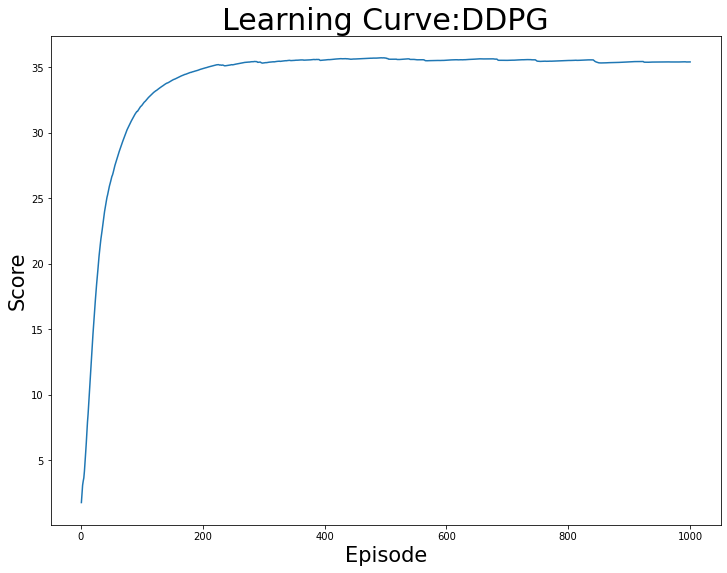

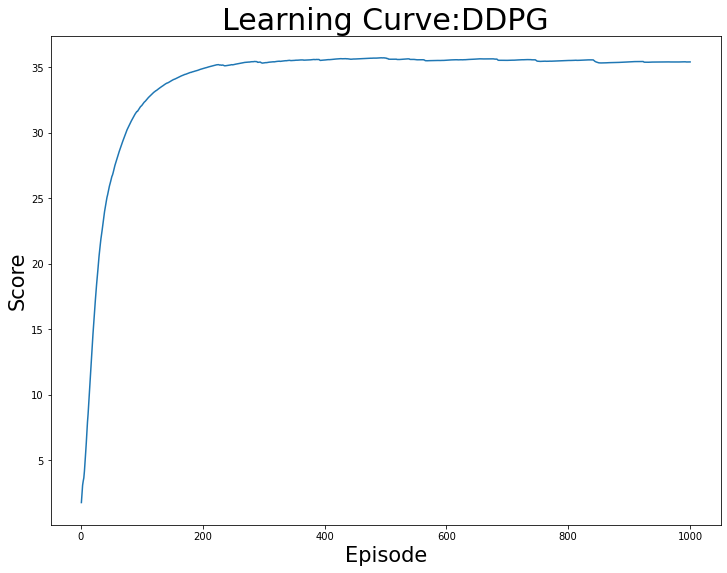

In [10]:
trainer.plt_results()
